<a href="https://colab.research.google.com/github/arifchuuw/python/blob/mainbranch/CNN_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "arifchu" 
os.environ['KAGGLE_KEY'] = "70d6f91d2a9a2d4eb99f7097ae948db6" 
!kaggle competitions download -c dogs-vs-cats # api copied from kaggle

100% 811M/812M [00:10<00:00, 72.1MB/s]
100% 812M/812M [00:10<00:00, 77.7MB/s]


In [ ]:
# Upload data and extract the contents
from zipfile import ZipFile

file_name = "/content/dogs-vs-cats.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

done


In [ ]:
train_file_name = "/content/train.zip"

with ZipFile(train_file_name, 'r') as zip:
  zip.extractall(".")
  print('done')

done


In [ ]:
train_file_name = "/content/test1.zip"

with ZipFile(train_file_name, 'r') as zip:
  zip.extractall(".")
  print('done')

done


In [ ]:
import os
import cv2
import time
import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T
from torchvision.utils import make_grid
from torchvision.models import resnet50

from sklearn.model_selection import train_test_split

from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
DIR_TRAIN = "/content/train"
DIR_TEST = "/content/test1"

In [ ]:
imgs = os.listdir(DIR_TRAIN) 
test_imgs = os.listdir(DIR_TEST)

print(imgs[:5])
print(test_imgs[:5])

['cat.1207.jpg', 'cat.2601.jpg', 'cat.708.jpg', 'dog.4728.jpg', 'cat.7944.jpg']
['6192.jpg', '4108.jpg', '491.jpg', '10296.jpg', '7762.jpg']


In [ ]:
dogs_list = [img for img in imgs if img.split(".")[0] == "dog"]
cats_list = [img for img in imgs if img.split(".")[0] == "cat"]

print("No of Dogs Images: ",len(dogs_list))
print("No of Cats Images: ",len(cats_list))

class_to_int = {"dog" : 0, "cat" : 1}
int_to_class = {0 : "dog", 1 : "cat"}

No of Dogs Images:  12500
No of Cats Images:  12500


In [ ]:
def get_train_transform():
    return T.Compose([
        T.RandomHorizontalFlip(p=0.5),
        T.RandomRotation(15),
        T.RandomCrop(204),
        T.ToTensor(),
        T.Normalize((0, 0, 0),(1, 1, 1))
    ])
    
def get_val_transform():
    return T.Compose([
        T.ToTensor(),
        T.Normalize((0, 0, 0),(1, 1, 1))
    ])

In [ ]:
class CatDogDataset(Dataset):
    
    def __init__(self, imgs, class_to_int, mode = "train", transforms = None):
        
        super().__init__()
        self.imgs = imgs
        self.class_to_int = class_to_int
        self.mode = mode
        self.transforms = transforms
        
    def __getitem__(self, idx):
        
        image_name = self.imgs[idx]
        img = Image.open(DIR_TRAIN + "/" + image_name)
        img = img.resize((224, 224))
        
        if self.mode == "train" or self.mode == "val":
        
            # Preparing class label
            label = self.class_to_int[image_name.split(".")[0]]
            label = torch.tensor(label, dtype = torch.float32)

            # Apply Transforms on image
            img = self.transforms(img)

            return img, label
        
        elif self.mode == "test":
            
            # Apply Transforms on image
            img = self.transforms(img)

            return img
            
        
    def __len__(self):
        return len(self.imgs)
    

In [ ]:
train_imgs, val_imgs = train_test_split(imgs, test_size = 0.25)

In [ ]:
train_dataset = CatDogDataset(train_imgs, class_to_int, mode = "train", transforms = get_train_transform())
val_dataset = CatDogDataset(val_imgs, class_to_int, mode = "val", transforms = get_val_transform())
test_dataset = CatDogDataset(test_imgs, class_to_int, mode = "test", transforms = get_val_transform())

train_data_loader = DataLoader(
    dataset = train_dataset,
    num_workers = 0,
    batch_size = 16,
    shuffle = True
)

val_data_loader = DataLoader(
    dataset = val_dataset,
    num_workers = 0,
    batch_size = 16,
    shuffle = True
)

test_data_loader = DataLoader(
    dataset = test_dataset,
    num_workers = 0,
    batch_size = 16,
    shuffle = True
)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
def accuracy(preds, trues):
    
    # Converting preds to 0 or 1
    preds = [1 if preds[i] >= 0.5 else 0 for i in range(len(preds))]
    
    # Calculating accuracy by comparing predictions with true labels
    acc = [1 if preds[i] == trues[i] else 0 for i in range(len(preds))]
    
    # Summing over all correct predictions
    acc = np.sum(acc) / len(preds)
    
    return (acc * 100)
    

In [ ]:
def train_one_epoch(train_data_loader):
    
    # Local Parameters
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()
    
    # Iterating over data loader
    for images, labels in train_data_loader:
        
        # Loading images and labels to device
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.reshape((labels.shape[0], 1)) # [N, 1] - to match with preds shape
        
        # Reseting Gradients
        optimizer.zero_grad()
        
        # Forward
        preds = model(images)
        
        # Calculating Loss
        _loss = criterion(preds, labels)
        loss = _loss.item()
        epoch_loss.append(loss)
        
        # Calculating Accuracy
        acc = accuracy(preds, labels)
        epoch_acc.append(acc)
        
        #Backward
        _loss.backward()
        optimizer.step()
    
    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time
    
    # Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)
    
    # Storing results to logs
    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(epoch_acc)
    train_logs["time"].append(total_time)
        
    return epoch_loss, epoch_acc, total_time
        

In [ ]:
def val_one_epoch(val_data_loader, best_val_acc):
    
    # Local Parameters
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()
    
    # Iterating over data loader
    for images, labels in val_data_loader:
        
        # Loading images and labels to device
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.reshape((labels.shape[0], 1)) # [N, 1] - to match with preds shape
        
        # Forward
        preds = model(images)
        
        # Calculating Loss
        _loss = criterion(preds, labels)
        loss = _loss.item()
        epoch_loss.append(loss)
        
        # Calculating Accuracy
        acc = accuracy(preds, labels)
        epoch_acc.append(acc)
    
    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time
    
    # Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)
    
    # Storing results to logs
    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(epoch_acc)
    val_logs["time"].append(total_time)
    
    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(),"resnet50_best.pth")
        
    return epoch_loss, epoch_acc, total_time, best_val_acc
        

In [ ]:
model = resnet50(pretrained = False)

# Modifying Head - classifier

model.fc = nn.Sequential(
    nn.Linear(2048, 1, bias = True),
    nn.Sigmoid()
)

In [ ]:
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

# Learning Rate Scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.5)

# Loss Function
criterion = nn.BCELoss()

# Logs - Helpful for plotting after training finishes
train_logs = {"loss" : [], "accuracy" : [], "time" : []}
val_logs = {"loss" : [], "accuracy" : [], "time" : []}

# Loading model to device
model.to(device)

# No of epochs 
epochs = 10

In [ ]:
best_val_acc = 0
for epoch in range(epochs):
    
    # Training
    loss, acc, _time = train_one_epoch(train_data_loader)
    
    # Print Epoch Details
    print("\nTraining")
    print("Epoch {}".format(epoch+1))
    print("Loss : {}".format(round(loss, 4)))
    print("Acc : {}".format(round(acc, 4)))
    print("Time : {}".format(round(_time, 4)))
    
    # Validation
    loss, acc, _time, best_val_acc = val_one_epoch(val_data_loader, best_val_acc)
    
    # Print Epoch Details
    print("\nValidating")
    print("Epoch {}".format(epoch+1))
    print("Loss : {}".format(round(loss, 4)))
    print("Acc : {}".format(round(acc, 4)))
    print("Time : {}".format(round(_time, 4)))


Training
Epoch 1
Loss : 0.6547
Acc : 61.8029
Time : 308.3369

Validating
Epoch 1
Loss : 0.6521
Acc : 64.383
Time : 51.6063

Training
Epoch 2
Loss : 0.5831
Acc : 69.2452
Time : 308.1121

Validating
Epoch 2
Loss : 0.5952
Acc : 68.0019
Time : 50.9153

Training
Epoch 3
Loss : 0.5036
Acc : 74.8431
Time : 303.4451

Validating
Epoch 3
Loss : 0.5051
Acc : 74.5908
Time : 50.9107

Training
Epoch 4
Loss : 0.4353
Acc : 79.4254
Time : 303.1642

Validating
Epoch 4
Loss : 0.4522
Acc : 79.2104
Time : 50.2088

Training
Epoch 5
Loss : 0.3794
Acc : 82.6723
Time : 303.6113

Validating
Epoch 5
Loss : 0.3538
Acc : 84.4118
Time : 50.3496

Training
Epoch 6
Loss : 0.3169
Acc : 86.1287
Time : 303.4635

Validating
Epoch 6
Loss : 0.32
Acc : 85.8184
Time : 51.0373

Training
Epoch 7
Loss : 0.2746
Acc : 88.1773
Time : 303.9412

Validating
Epoch 7
Loss : 0.2639
Acc : 88.7852
Time : 50.4591

Training
Epoch 8
Loss : 0.2424
Acc : 89.6742
Time : 303.8318

Validating
Epoch 8
Loss : 0.2347
Acc : 89.9105
Time : 50.5645

Tr

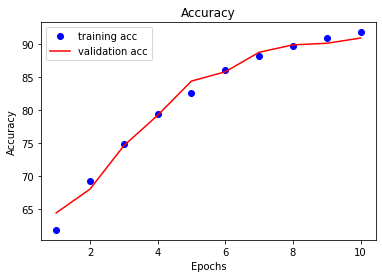

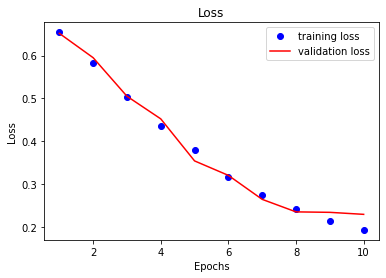

In [ ]:
### Plotting Results

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, 11, 1), train_logs["accuracy"], 'bo', label = "training acc")
plt.plot(np.arange(1, 11, 1), val_logs["accuracy"], 'r', label = "validation acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

# Loss
plt.title("Loss")
plt.plot(np.arange(1, 11, 1), train_logs["loss"], 'bo', label = "training loss")
plt.plot(np.arange(1, 11, 1), val_logs["loss"], 'r', label = "validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()
